1. [Creating a base code](#section_1)
2. [DC Readouts](#section_2)
3. [Optimizing the PRCL parameters](#section_3)
4. [Optimizing the Schnupp Asymmetry](#section_4)
5. [Optimized lengths](#section_5)
6. [Problem_1](#section_6)
7. [Optimizing the Reflectance](#section_7)
8. [Optimizing the Modulation Depth](#section_8)
9. [Power Recycling Gain](#section_9)
10. [Sensing Matrix](#section_10)
11. [Optimizing the Demodulation phase](#section_11)

<a name="section_1"></a>
# Creating a base code

In [1]:
import finesse
import numpy as np
import matplotlib.pyplot as plt

finesse.configure(plotting=True)
prmi=finesse.Model()
prmi.parse("""
#Laser
l laser P=1
s s0 laser.p1 eom.p1 L=1

#EOMS
mod eom midx=0.3 f=45497355 order=1                      #Phase modulating the laser @ 454497355Hz
s s2 eom.p2 Fi.p1 L=1

#Faraday isolator
dbs Fi
s s3 Fi.p3 prmar.p1 L=0

#PRM

m prmar R=0 L=4e-5 Rc=11.009
s sprmarpr prmar.p2 PRM.p1 L=0.0737 nr=1.4496 
m PRM L=8.5e-06 T=0.03
s sPRBS PRM.p2 BS.p1 L=0                                 #Initially set as zero

#Beam Splitter
bs BS R=0.5 L=3.75e-05 alpha=45 
s sBSAR1 BS.p3 BSAR1.p1 L=0.0687 nr=1.4496
bs BSAR1 R=5e-5 L=0 phi=0 alpha=-29.195
s sBSAR2 BS.p4 BSAR2.p1 L=0.0687 nr=1.4496
bs BSAR2 R=5e-5 L=0 phi=0 alpha=29.195


#ITMx
s michx BSAR1.p3 ITMxAR.p1 L=0                           #Initially set as zero
m ITMxAR R=0 L=2e-5
s sITMxARITM ITMxAR.p2 ITMx.p1 L=0.2 nr=1.4496
m ITMx L=3.75e-05 T=0.014 Rc=-1934

#ITMy
s michy BS.p2 ITMyAR.p1 L=0                              #Initially set as zero
m ITMyAR R=0 L=2e-5
s sITMyARITM ITMyAR.p2 ITMy.p1 L=0.2 nr=1.4496
m ITMy L=3.75e-05 T=0.014 Rc=-1934

#Photo detectors

pd AS_dc BS.p4.o
pd POP_dc PRM.p2.o
pd REFL_dc PRM.p1.o
pd ArmTrans_dc ITMy.p2.o
pd in PRM.p1.i

#Amplitude detectors

ad BS_f0 BS.p1.o f=0
ad BS_f2 BS.p1.o f=45497355
ad AS_f0 BSAR2.p3.o f=0
#ad AS_f1 BS.p4.o f=9099471
ad AS_f2 BS.p4.o f=45497355
ad POP_f0 PRM.p2.o f=0
#ad POP_f1 PRM.p2.o f=9099471
ad POP_f2 PRM.p2.o f=45497355

pd1 REFLf1I PRM.p1.o f=45497355 phase=0
pd1 REFLf1Q PRM.p1.o f=45497355 phase=90

pd1 ASf1I BS.p4.o f=45497355 phase=0
pd1 ASf1Q BS.p4.o f=45497355 phase=90

pd1 POPf1I PRM.p2.o f=45497355 phase=0
pd1 POPf1Q PRM.p2.o f=45497355 phase=90

#Sweeping the ITMy mirror

xaxis(ITMy.phi,lin,-200,200,10000)
""")

<a name="section_2"></a>
## Plotting the DC readouts at POP, AS, REFL, Arm Transmission ports

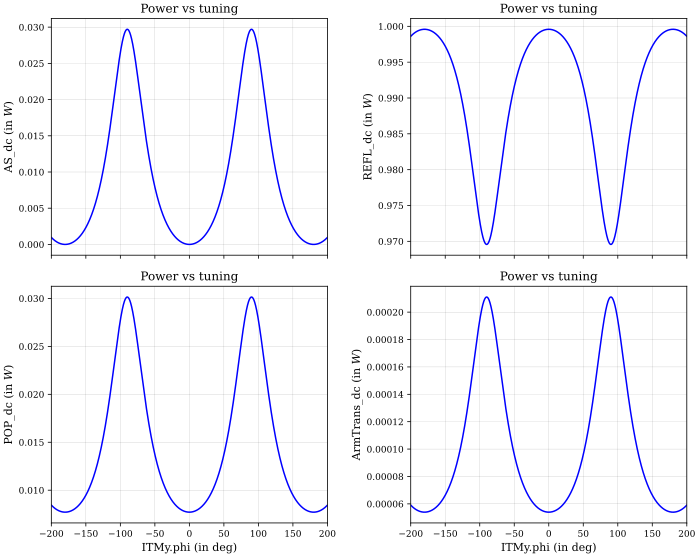

In [2]:
out=prmi.run()
AS_dc=[]
ArmTrans_dc=[]
POP_dc=[]
REFL_dc=[]

phi=np.linspace(-200,200,10000)
for i in range(10000):
    AS_dc.append(out["AS_dc"][i])
    POP_dc.append(out["POP_dc"][i])
    REFL_dc.append(out["REFL_dc"][i])
    ArmTrans_dc.append(out["ArmTrans_dc"][i])
    
fig,plots=plt.subplots(2,2,figsize=(10,8),sharex=True)

plots[0,0].plot(phi,AS_dc)
plots[0,0].set_ylabel("AS_dc (in $W$)")
plots[0,0].set_title("Power vs tuning")

plots[1,0].plot(phi,POP_dc)
plots[1,0].set_ylabel("POP_dc (in $W$)")
plots[1,0].set_title("Power vs tuning")
plots[1,0].set_xlabel("ITMy.phi (in deg)") 

plots[0,1].plot(phi,REFL_dc)
plots[0,1].set_ylabel("REFL_dc (in $W$)")
plots[0,1].set_title("Power vs tuning")

plots[1,1].plot(phi,ArmTrans_dc)
plots[1,1].set_ylabel("ArmTrans_dc (in $W$)")
plots[1,1].set_title("Power vs tuning")
plots[1,1].set_xlabel("ITMy.phi (in deg)")

fig.tight_layout()    

<a name="section_3"></a>
## Sweeping the PRM to plot the a readouts. I also locate the peaks of the carrier and sideband amplitudes in the PRC.

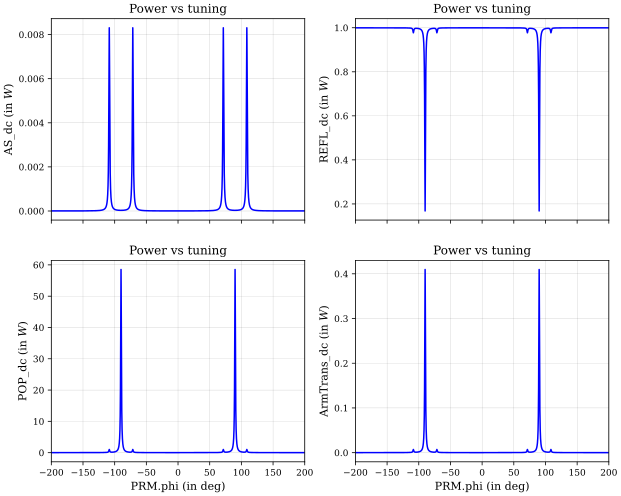

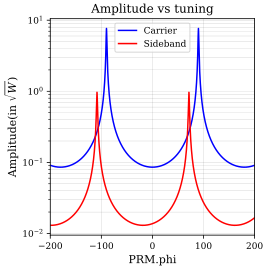

In [3]:
prmi.parse("xaxis(PRM.phi,lin,-200,200,10000)")
out=prmi.run()
AS_dc=[]
ArmTrans_dc=[]
POP_dc=[]
REFL_dc=[]
POP_f0=[]
POP_f2=[]

phi=np.linspace(-200,200,10000)
for i in range(10000):
    AS_dc.append(out["AS_dc"][i])
    POP_dc.append(out["POP_dc"][i])
    REFL_dc.append(out["REFL_dc"][i])
    ArmTrans_dc.append(out["ArmTrans_dc"][i])
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))
    
fig,plots=plt.subplots(2,2,figsize=(10,8),sharex=True)

plots[0,0].plot(phi,AS_dc)
plots[0,0].set_ylabel("AS_dc (in $W$)")
plots[0,0].set_title("Power vs tuning")

plots[1,0].plot(phi,POP_dc)
plots[1,0].set_ylabel("POP_dc (in $W$)")
plots[1,0].set_title("Power vs tuning")
plots[1,0].set_xlabel("PRM.phi (in deg)")

plots[0,1].plot(phi,REFL_dc)
plots[0,1].set_ylabel("REFL_dc (in $W$)")
plots[0,1].set_title("Power vs tuning")

plots[1,1].plot(phi,ArmTrans_dc)
plots[1,1].set_ylabel("ArmTrans_dc (in $W$)")
plots[1,1].set_title("Power vs tuning")
plots[1,1].set_xlabel("PRM.phi (in deg)")

fig,a=plt.subplots(1,figsize=(4,4))
a.semilogy(phi,POP_f0,label="Carrier")
a.semilogy(phi,POP_f2,label="Sideband")
a.set_xlabel("PRM.phi")
a.set_ylabel("Amplitude(in $\sqrt{W}$)")
a.set_title("Amplitude vs tuning")
a.legend(loc="best")

fig.tight_layout()

Now, I set random PRC lengths to see how these peaks are shifted.<br>
I then optimize these parameters to resonate the sideband in the PRC.

SB attains peak amplitudes at PRM.phi: [-32.94329433 147.07470747]


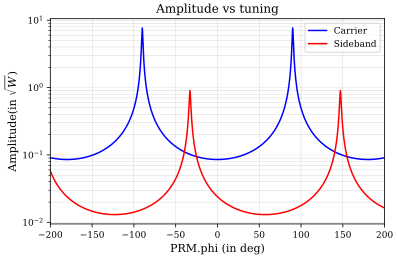

In [4]:
### Setting random PRCL parameters.
prmi.michy.L=4.49
prmi.michx.L=4.51 ### The mich lengths have a randomly set Schnupp of 0.01m, which is optimized separately.
prmi.sPRBS.L=4
prmi.parse("xaxis(PRM.phi,lin,-200,200,10000)")
out=prmi.run()

POP_f0=[]
POP_f2=[]
AS_f0=[]
AS_f2=[]

phi=np.linspace(-200,200,10000)
for i in range(10000):
    AS_f0.append(abs(out["AS_f0"][i]))
    AS_f2.append(abs(out["AS_f2"][i]))
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))

fig.tight_layout()    
plt.semilogy(phi,POP_f0,label="Carrier")
plt.semilogy(phi,POP_f2,label="Sideband")
plt.xlabel("PRM.phi (in deg)")
plt.ylabel("Amplitude(in $\sqrt{W}$)")
plt.title("Amplitude vs tuning")
plt.legend(loc="best")

### The f2 Sideband is not resonant for these randomly set length parameters.

### We now locate the amplitude peaks.

import scipy
from scipy import signal
sb_peaks,_=signal.find_peaks(POP_f2)
print("SB attains peak amplitudes at PRM.phi:",phi[sb_peaks])

In the following cell, I find the length corresponding to the one of the two PRM.phi, that were located in the previous cell.<br>
We will bring the peak of SB to the zero coordinate of PRM (Carrier is already anti-resonant)

PR-BS length:  6.6938325585217555 m


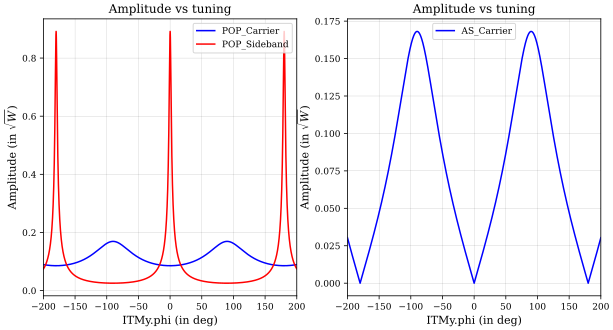

In [5]:
Lambda=3E8/45497355
prmi.sPRBS.L=4+Lambda*phi[sb_peaks[1]]/360 ### 4 was the initial PR-BS distance.
prmi.parse("xaxis(ITMy.phi,lin,-200,200,10000)") 
prmi.run()
out=prmi.run()

POP_f0=[]
POP_f2=[]
AS_f0=[]
AS_f2=[]

phi=np.linspace(-200,200,10000)
for i in range(10000):
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))
    AS_f0.append(abs(out["AS_f0"][i]))
    AS_f2.append(abs(out["AS_f2"][i]))    

fig,a=plt.subplots(1,2,figsize=(10,5))
a[0].plot(phi,POP_f0,label="POP_Carrier")
a[0].plot(phi,POP_f2,label="POP_Sideband")
a[0].set_xlabel("ITMy.phi (in deg)")
a[0].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[0].set_title("Amplitude vs tuning")
a[0].legend(loc="best")

a[1].plot(phi,AS_f0,label="AS_Carrier")
a[1].set_xlabel("ITMy.phi (in deg)")
a[1].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[1].set_title("Amplitude vs tuning")
a[1].legend(loc="best")
print("PR-BS length: ",prmi.sPRBS.L)

The SB is resonant in the PRC while the carrier is anti-resonant.

<a name="section_4"></a>
## Optimizing the Schnupp asymmetry to maximize the transmission to the AS Port

In [6]:
### Optimizing the randomly chosen Schnupp asymmetry of 0.01 m, We will define a function, which can alter the Michx and Michy 
### lengths. We optimize it by minimizing the negative of the function output!
def f(del_l):
    prmi.michx.L=4.51+del_l
    prmi.michy.L=4.49-del_l
    out=prmi.run()
    AS_f2=[]
    for i in range(10000):
        AS_f2.append(out["AS_f2"][i])
    return abs(max(AS_f2)-min(AS_f2))
    
from scipy.optimize import minimize_scalar
res = minimize_scalar(lambda del_l: -f(del_l), bounds = [0.0, 0.30], method='bounded')
asym = res.x
print(f"{asym} m is the optimised asymmetry that allows a maximum SB transmission of {f(asym)}","W^0.5 to the AS port")

0.04820229093155088 m is the optimised asymmetry that allows a maximum SB transmission of 0.12189936485069776 W^0.5 to the AS port


<a name="section_5"></a>
## Displaying the optimized lengths

In [7]:
### Optimized lengths
Schnupp=prmi.michx.L.value-4.5
pr_bs_opt=prmi.sPRBS.L.value
print(f"Optimized MichX:{prmi.michx.L.value:.4f} m")
print(f"Optimized MichY:{prmi.michy.L.value:.4f} m")
print(f"Optimized Schnupp:{Schnupp:.4f} m")
print(f"Optimized PR-BS length:{prmi.sPRBS.L.value:.4f} m")

Optimized MichX:4.5582 m
Optimized MichY:4.4418 m
Optimized Schnupp:0.0582 m
Optimized PR-BS length:6.6938 m


## Displaying how these parameters reflect on the plots.

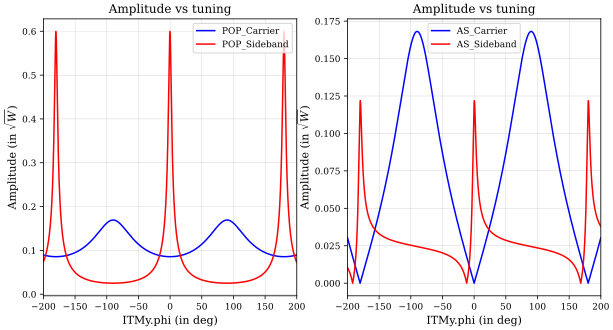

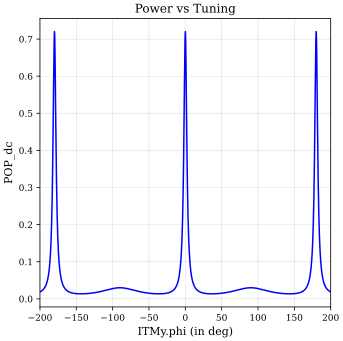

In [8]:
### Results
prmi.parse("xaxis(ITMy.phi,lin,-200,200,10000)")
out=prmi.run()

### Creating empty lists..

POP_f0=[]
POP_f2=[]
AS_f0=[]
AS_f2=[]
POP_dc=[]

phi=np.linspace(-200,200,10000)

### Appending the Amplitudes and Power..

for i in range(10000):
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))
    AS_f0.append(abs(out["AS_f0"][i]))
    AS_f2.append(abs(out["AS_f2"][i]))
    POP_dc.append(abs(out["POP_dc"][i]))  
    
### Creating empty lists..
fig,a=plt.subplots(1,2,figsize=(10,5))
a[0].plot(phi,POP_f0,label="POP_Carrier")
a[0].plot(phi,POP_f2,label="POP_Sideband")
a[0].set_xlabel("ITMy.phi (in deg)")
a[0].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[0].set_title("Amplitude vs tuning")
a[0].legend(loc="best")

a[1].plot(phi,AS_f0,label="AS_Carrier")
a[1].plot(phi,AS_f2,label="AS_Sideband")
a[1].set_xlabel("ITMy.phi (in deg)")
a[1].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[1].set_title("Amplitude vs tuning")
a[1].legend(loc="best")

fig,plot=plt.subplots(1,figsize=(5,5))
plot.plot(phi,POP_dc)
plot.set_xlabel("ITMy.phi (in deg)")
plot.set_ylabel("POP_dc")
plot.set_title("Power vs Tuning")


fig.tight_layout()


<a name="section_6"></a>
## Problem_1

In the following cell, I locate the peaks of SB in the POP and AS ports to see if they occur simultaneously when the ITMy is swept.

In [9]:
import scipy 
from scipy import signal
peaks_POP_Sb,_=signal.find_peaks(POP_f2)
peaks_AS_Sb,_=signal.find_peaks(AS_f2)

phi_POP=phi[peaks_POP_Sb]
phi_AS=phi[peaks_AS_Sb]
print("SB is resonant at ITMy.phi:",phi_POP,"degrees")
print("\nMax trans to AS occurs at ITMy.phi:",phi_AS,"degrees")


power_buildup_1=max(POP_dc)
print(power_buildup_1,"W")

SB is resonant at ITMy.phi: [-180.2380238   -0.220022   179.7979798] degrees

Max trans to AS occurs at ITMy.phi: [-179.7179718    0.30003    180.3180318] degrees
0.7199908858503594 W


#### The peaks do not occur together. I am puzzled on this..<br>
#### But the peaks do occur together when PRM is swept, instead of ITMy

SB is resonant at ITMy.phi: [-1.80118012e+02 -1.00010001e-01  1.79917992e+02] degrees

Max trans to AS occurs at ITMy.phi: [-1.80118012e+02 -1.00010001e-01  1.79917992e+02] degrees


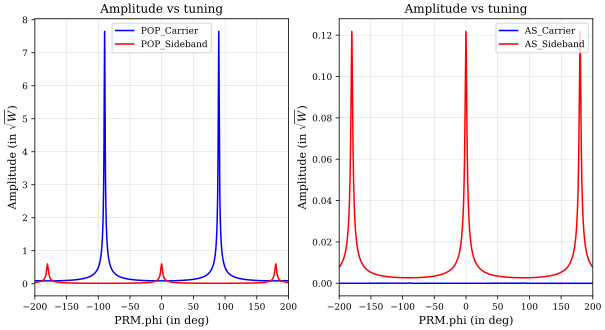

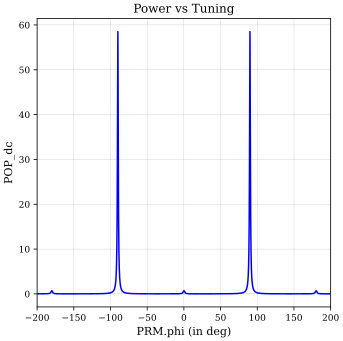

In [10]:
prmi.parse("xaxis(PRM.phi,lin,-200,200,10000)")
out=prmi.run()

POP_f0=[]
POP_f2=[]
AS_f0=[]
AS_f2=[]
POP_dc=[]

phi=np.linspace(-200,200,10000)

for i in range(10000):
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))
    AS_f0.append(abs(out["AS_f0"][i]))
    AS_f2.append(abs(out["AS_f2"][i]))
    POP_dc.append(abs(out["POP_dc"][i]))  
    
fig,a=plt.subplots(1,2,figsize=(10,5))
a[0].plot(phi,POP_f0,label="POP_Carrier")
a[0].plot(phi,POP_f2,label="POP_Sideband")
a[0].set_xlabel("PRM.phi (in deg)")
a[0].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[0].set_title("Amplitude vs tuning")
a[0].legend(loc="best")

a[1].plot(phi,AS_f0,label="AS_Carrier")
a[1].plot(phi,AS_f2,label="AS_Sideband")
a[1].set_xlabel("PRM.phi (in deg)")
a[1].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[1].set_title("Amplitude vs tuning")
a[1].legend(loc="best")

fig,plot=plt.subplots(1,figsize=(5,5))
plot.plot(phi,POP_dc)
plot.set_xlabel("PRM.phi (in deg)")
plot.set_ylabel("POP_dc")
plot.set_title("Power vs Tuning")

fig.tight_layout()


import scipy 
from scipy import signal
peaks_POP_Sb,_=signal.find_peaks(POP_f2)
peaks_AS_Sb,_=signal.find_peaks(AS_f2)

phi_POP=phi[peaks_POP_Sb]
phi_AS=phi[peaks_AS_Sb]
print("SB is resonant at ITMy.phi:",phi_POP,"degrees")
print("\nMax trans to AS occurs at ITMy.phi:",phi_AS,"degrees")

<a name="section_7"></a>
# Optimizing the Reflectance

In the following cell, I create a model to optimize the reflectance of the PRM to get maximum power buildup in the PRC.<br>
I do that by scanning the R value of PRM and probing the POP_dc output.<br>
Basically, I am impedance matching the Michelson and the PRM.

R_opt: 0.941986192469247


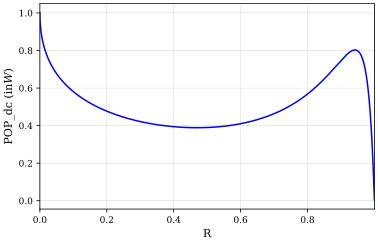

In [11]:
### I have assumed that the PRM's loss is constant at 8.5E-6.

### I have used the optimized PRC parameters which sees a dark AS port for carrier.

prmi2=finesse.Model()
prmi2.parse("""
var R 0                                         ### Defining a variable R, which is later swept

#Laser
l laser P=1
s s0 laser.p1 eom1.p1 L=1

#EOMS
mod eom1  f=9099471 midx=0 order=1
s s1 eom1.p2 eom2.p1 L=1
mod eom2  f=45497355 midx=0.3 order=1
s s2 eom2.p2 Fi.p1 L=1

#Faraday isolator
dbs Fi
s s3 Fi.p3 prmar.p1 L=0

#PRM

m prmar R=0 T=0.99996 L=4e-5 Rc=[11.009, 11.009]
s sprmarpr prmar.p2 PRM.p1 L=0.0737 nr=1.4496 
m PRM R=R T=1-R-8.5e-6 L=8.5e-06                ### Setting the variable to R and T parameters
s sPRBS PRM.p2 BS.p1 L=6.6938325585217555                         

#Beam Splitter
bs BS R=0.5 T=0.4999625 L=3.75e-05 alpha=45 
s sBSAR1 BS.p3 BSAR1.p1 L=0.0687 nr=1.4496
bs BSAR1 R=5e-5 T=0.99995 L=0 phi=0 alpha=-29.195
s sBSAR2 BS.p4 BSAR2.p1 L=0.0687 nr=1.4496
bs BSAR2 R=5e-5 T=0.99995 L=0 phi=0 alpha=29.195


#ITMx
s michx BSAR1.p3 ITMxAR.p1 L=4.5582022909315505                         
m ITMxAR R=0 T=0.99998 L=2e-5
s sITMxARITM ITMxAR.p2 ITMx.p1 L=0.2 nr=1.4496
m ITMx R=0.9859625  T=0.014 L=3.75e-05 Rc=[-1934.0, -1934.0]

#ITMy
s michy BS.p2 ITMyAR.p1 L=4.4417977090684495                          
m ITMyAR R=0 T=0.99998 L=2e-5
s sITMyARITM ITMyAR.p2 ITMy.p1 L=0.2 nr=1.4496
m ITMy R=0.9859625  T=0.014 L=3.75e-05 Rc=[-1934.0, -1934.0]


pd POP_dc PRM.p2.o

xaxis(R,lin,0,1-8.5e-6,10000)                     ### Scanning the variable R from 0 to 1-8.5e-6

""")
out=prmi2.run()
POP_dc=[]
for i in range(10000):
    POP_dc.append(out["POP_dc"][i])
R=np.linspace(0,1-8.5e-6,10000)
plt.plot(R,POP_dc)
plt.xlabel("R")
plt.ylabel("POP_dc (in$W$)")
import scipy 
from scipy import signal
peak,_=signal.find_peaks(POP_dc)
R_opt=R[peak[0]]
print("R_opt:",R_opt)              ### R=0 can not be used!

Plotting the new results.

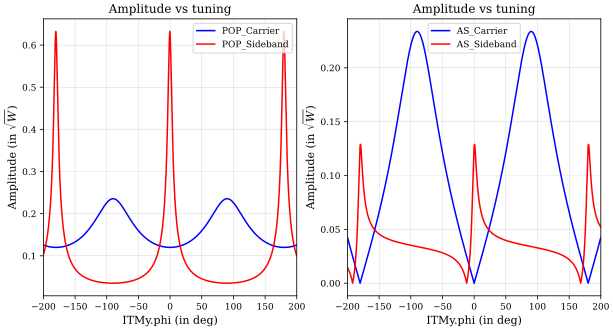

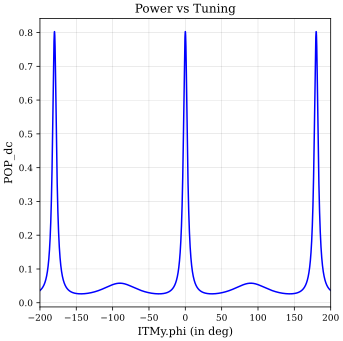

In [12]:
prmi3=prmi.deepcopy()
prmi3.PRM.R=R_opt
prmi3.PRM.T=1-8.5e-6-R_opt
prmi3.eom.midx=0.3
prmi3.parse("xaxis(ITMy.phi,lin,-200,200,10000)")
out=prmi3.run()

POP_f0=[]
POP_f2=[]
AS_f0=[]
AS_f2=[]
POP_dc=[]

phi=np.linspace(-200,200,10000)


for i in range(10000):
    POP_f0.append(abs(out["POP_f0"][i]))
    POP_f2.append(abs(out["POP_f2"][i]))
    AS_f0.append(abs(out["AS_f0"][i]))
    AS_f2.append(abs(out["AS_f2"][i]))
    POP_dc.append(abs(out["POP_dc"][i]))   

fig,a=plt.subplots(1,2,figsize=(10,5))
a[0].plot(phi,POP_f0,label="POP_Carrier")
a[0].plot(phi,POP_f2,label="POP_Sideband")
a[0].set_xlabel("ITMy.phi (in deg)")
a[0].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[0].set_title("Amplitude vs tuning")
a[0].legend(loc="best")

a[1].plot(phi,AS_f0,label="AS_Carrier")
a[1].plot(phi,AS_f2,label="AS_Sideband")
a[1].set_xlabel("ITMy.phi (in deg)")
a[1].set_ylabel("Amplitude (in $\sqrt{W}$)")
a[1].set_title("Amplitude vs tuning")
a[1].legend(loc="best")

fig,plot=plt.subplots(1,figsize=(5,5))
plot.plot(phi,POP_dc)
plot.set_xlabel("ITMy.phi (in deg)")
plot.set_ylabel("POP_dc")
plot.set_title("Power vs Tuning")
fig.tight_layout()

Checking the increase of power in the PRC after optimizing the R of PRM.

In [13]:
power_buildup_2=max(POP_dc)
increase=power_buildup_2-power_buildup_1
print(increase,"W")

0.08274848524403433 W


<a name="section_8"></a>
# Optimizing the Modulation depth

midx_opt: 1.8411841184118412


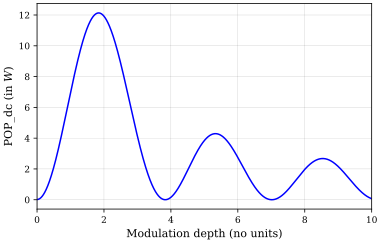

In [14]:
prmi3.parse("xaxis(eom.midx,lin,0,10,10000)")
POP_dc=[]
out=prmi3.run()
midx=np.linspace(0,10,10000)
for i in range(10000):
    POP_dc.append(out["POP_dc"][i])
plt.plot(midx,POP_dc)
plt.xlabel("Modulation depth (no units)")
plt.ylabel("POP_dc (in $W$)")
import scipy
from scipy import signal

peaks,_=signal.find_peaks(POP_dc)
midx_opt=midx[peaks[0]]
print("midx_opt:",midx_opt)

<a name="section_9"></a>
# Power Recycling Gain

Power recycling gain:  12.134780356008795


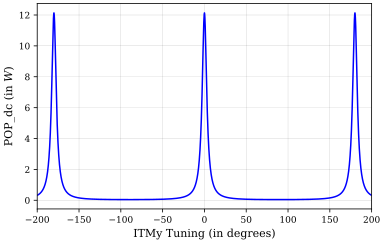

In [15]:
prmi.PRM.R=prmi3.PRM.R
prmi.PRM.T=prmi3.PRM.T
prmi.eom.midx=midx_opt
prmi.parse("xaxis(ITMy.phi,lin,-200,200,10000)")
phi=np.linspace(-200,200,10000)
out=prmi.run()
POP_dc=[]
for i in range(10000):
    POP_dc.append(out["POP_dc"][i])
plt.plot(phi,POP_dc)
plt.xlabel("ITMy Tuning (in degrees)")
plt.ylabel("POP_dc (in $W$)")
PR_gain=max(POP_dc)/1
print("Power recycling gain: ",PR_gain)

<a name="section_10"></a>
# Sensing Matrix 

I start with dithering the pr-bs length, this in turn dithers the PRCl dof. It does not have any consequence on the MICH dof.

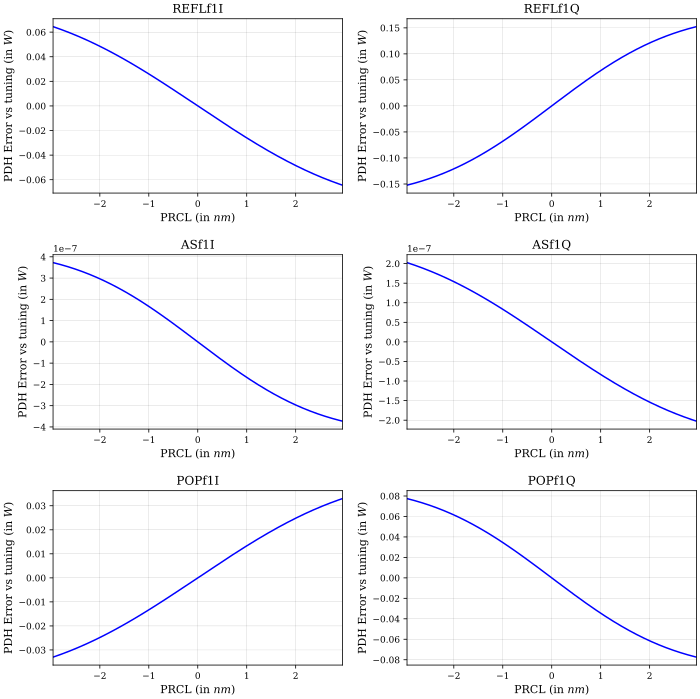

In [16]:
prmi.parse("xaxis(PRM.phi,lin,-1,1,10000)") #Restricting to the linear region
REFLf1I=[]
REFLf1Q=[]
ASf1I=[]
ASf1Q=[]
POPf1I=[]
POPf1Q=[]

lim=1*1064/360
prcl=np.linspace(-lim,lim,10000)
out=prmi.run()

import matplotlib.pyplot as plt
for i in range(10000):
    REFLf1I.append(out["REFLf1I"][i])
    ASf1I.append(out["ASf1I"][i])
    POPf1I.append(out["POPf1I"][i])
    REFLf1Q.append(out["REFLf1Q"][i])
    ASf1Q.append(out["ASf1Q"][i])
    POPf1Q.append(out["POPf1Q"][i])    
fig,plots=plt.subplots(3,2,figsize=(10,10),sharex=False)

plots[0,0].plot(prcl,REFLf1I)
plots[0,0].set_title("REFLf1I")
plots[0,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0,0].set_xlabel("PRCL (in $nm$)")

plots[1,0].plot(prcl,ASf1I)
plots[1,0].set_title("ASf1I")
plots[1,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1,0].set_xlabel("PRCL (in $nm$)")

plots[0,1].plot(prcl,REFLf1Q)
plots[0,1].set_title("REFLf1Q")
plots[0,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0,1].set_xlabel("PRCL (in $nm$)")

plots[1,1].plot(prcl,ASf1Q)
plots[1,1].set_title("ASf1Q")
plots[1,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1,1].set_xlabel("PRCL (in $nm$)")

plots[2,0].plot(prcl,POPf1I)
plots[2,0].set_title("POPf1I")
plots[2,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2,0].set_xlabel("PRCL (in $nm$)")

plots[2,1].plot(prcl,POPf1Q)
plots[2,1].set_title("POPf1Q")
plots[2,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2,1].set_xlabel("PRCL (in $nm$)")
fig.tight_layout()
  

In [17]:
### Short variable names->
# slope_REFLf1I_dithered prcl => s_RI_p
# slope_POPf1Q_dithered mich => s_PI_m
# signal_ASf1I_dithered prcl => sig_RI_p
# signal_ASf1Q_dithered mich => sig_AQ_m

### PRCL =>
s_RI_p=np.polyfit(prcl*1e-9,REFLf1I,1)[0]
s_RQ_p=np.polyfit(prcl*1e-9,REFLf1Q,1)[0]
s_AI_p=np.polyfit(prcl*1e-9,ASf1I,1)[0]
s_AQ_p=np.polyfit(prcl*1e-9,ASf1Q,1)[0]
s_PI_p=np.polyfit(prcl*1e-9,POPf1I,1)[0]
s_PQ_p=np.polyfit(prcl*1e-9,POPf1Q,1)[0]

sig_RI_p="{:e}".format(s_RI_p)
sig_RQ_p="{:e}".format(s_RQ_p)
sig_AI_p="{:e}".format(s_AI_p)
sig_AQ_p="{:e}".format(s_AQ_p)
sig_PI_p="{:e}".format(s_PI_p)
sig_PQ_p="{:e}".format(s_PQ_p)

Next, I dither the Michy length, this disturbance has effects both in MICH and PRCL, We will therefore have to separate them, I use simple linear algebra for the same.

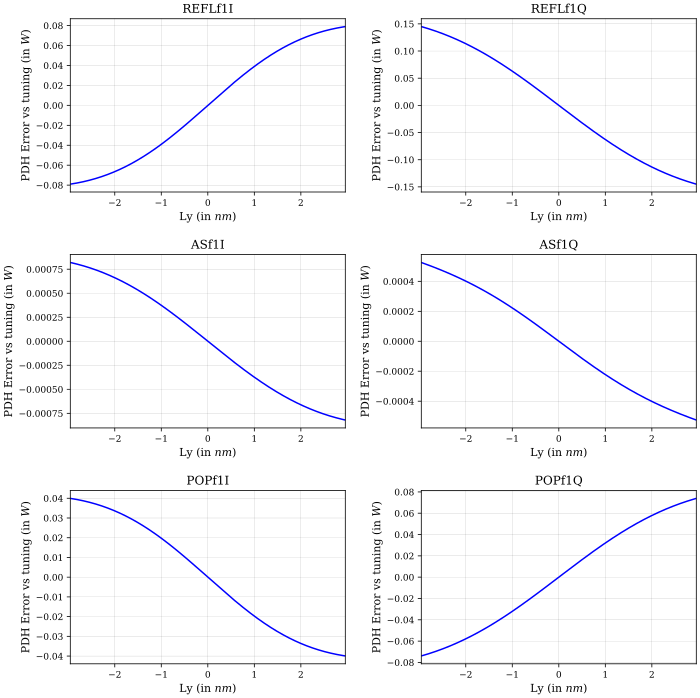

In [18]:
prmi.parse("xaxis(ITMy.phi,lin,-2,2,10000)") #Restricting to the linear region.
REFLf1I=[]
REFLf1Q=[]
ASf1I=[]
ASf1Q=[]
POPf1I=[]
POPf1Q=[]

lim=2*1064/360
ly=np.linspace(-lim,lim,10000)
out=prmi.run()

import matplotlib.pyplot as plt
for i in range(10000):
    REFLf1I.append(out["REFLf1I"][i])
    ASf1I.append(out["ASf1I"][i])
    POPf1I.append(out["POPf1I"][i])
    REFLf1Q.append(out["REFLf1Q"][i])
    ASf1Q.append(out["ASf1Q"][i])
    POPf1Q.append(out["POPf1Q"][i])    
fig,plots=plt.subplots(3,2,figsize=(10,10),sharex=False)

plots[0,0].plot(prcl,REFLf1I)
plots[0,0].set_title("REFLf1I")
plots[0,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0,0].set_xlabel("Ly (in $nm$)")

plots[1,0].plot(prcl,ASf1I)
plots[1,0].set_title("ASf1I")
plots[1,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1,0].set_xlabel("Ly (in $nm$)")

plots[0,1].plot(prcl,REFLf1Q)
plots[0,1].set_title("REFLf1Q")
plots[0,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0,1].set_xlabel("Ly (in $nm$)")

plots[1,1].plot(prcl,ASf1Q)
plots[1,1].set_title("ASf1Q")
plots[1,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1,1].set_xlabel("Ly (in $nm$)")

plots[2,0].plot(prcl,POPf1I)
plots[2,0].set_title("POPf1I")
plots[2,0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2,0].set_xlabel("Ly (in $nm$)")

plots[2,1].plot(prcl,POPf1Q)
plots[2,1].set_title("POPf1Q")
plots[2,1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2,1].set_xlabel("Ly (in $nm$)")
fig.tight_layout()
  

In [19]:
### MICH =>
s_RI_m=np.polyfit(ly*1e-9,REFLf1I,1)[0]
s_RQ_m=np.polyfit(ly*1e-9,REFLf1Q,1)[0]
s_AI_m=np.polyfit(ly*1e-9,ASf1I,1)[0]
s_AQ_m=np.polyfit(ly*1e-9,ASf1Q,1)[0]
s_PI_m=np.polyfit(ly*1e-9,POPf1I,1)[0]
s_PQ_m=np.polyfit(ly*1e-9,POPf1Q,1)[0]

sig_RI_m="{:e}".format(0.5*s_RI_p-s_RI_m)
sig_RQ_m="{:e}".format(0.5*s_RQ_p-s_RQ_m)
sig_AI_m="{:e}".format(0.5*s_AI_p-s_AI_m)
sig_AQ_m="{:e}".format(0.5*s_AQ_p-s_AQ_m)
sig_PI_m="{:e}".format(0.5*s_PI_p-s_PI_m)
sig_PQ_m="{:e}".format(0.5*s_PQ_p-s_PQ_m)

In [20]:
from tabulate import tabulate
M=[["Signal","REFLf1I","REFLf1Q","ASf1I","ASf1Q","POPf1I","POPf1Q"],
   ["PRCL (in W/m)",sig_RI_p,sig_RQ_p,sig_AI_p,sig_AQ_p,sig_PI_p,sig_PQ_p],
  ["MICH (in W/m)",sig_RI_m,sig_RQ_m,sig_AI_m,sig_AQ_m,sig_PI_m,sig_PQ_m]]
print(tabulate(M))

-------------  -------------  ------------  -------------  -------------  ------------  -------------
Signal         REFLf1I        REFLf1Q       ASf1I          ASf1Q          POPf1I        POPf1Q
PRCL (in W/m)  -2.361359e+07  5.821987e+07  -1.427469e+02  -7.479022e+01  1.208368e+07  -2.960219e+07
MICH (in W/m)  -2.761792e+07  5.651116e+07  1.585460e+05   9.758012e+04   1.403439e+07  -2.876964e+07
-------------  -------------  ------------  -------------  -------------  ------------  -------------


<a name ='section_11'></a>
# Optimizing the demodulation phase

I am building a new model with the same optimized parametres as the previous one, except that I have added only the Pd1 elements which extract the PDH signals at REFL,POP,AS ports.<br>
PRCL wil be dithered first.

In [21]:
prmi5=finesse.Model()
prmi5.parse("""
#Laser
l laser P=1
s s0 laser.p1 eom.p1 L=1

#EOMS
mod eom  f=45497355 midx=1.8411841184118412 order=1                      
s s2 eom.p2 Fi.p1 L=1

#Faraday isolator
dbs Fi
s s3 Fi.p3 prmar.p1 L=0

#PRM

m prmar R=0 T=0.99996 L=4e-5 Rc=[11.009, 11.009]
s sprmarpr prmar.p2 PRM.p1 L=0.0737 nr=1.4496 
m PRM R=0.941986192469247  T=0.05800530753075306 L=8.5e-06
s sPRBS PRM.p2 BS.p1 L=6.6938325585217555                              

#Beam Splitter
bs BS R=0.5 T=0.4999625 L=3.75e-05 alpha=45 
s sBSAR1 BS.p3 BSAR1.p1 L=0.0687 nr=1.4496
bs BSAR1 R=5e-5 T=0.99995 L=0 phi=0 alpha=-29.195
s sBSAR2 BS.p4 BSAR2.p1 L=0.0687 nr=1.4496
bs BSAR2 R=5e-5 T=0.99995 L=0 phi=0 alpha=29.195


#ITMx
s michx BSAR1.p3 ITMxAR.p1 L=4.5582022909315505                           
m ITMxAR R=0 T=0.99998 L=2e-5
s sITMxARITM ITMxAR.p2 ITMx.p1 L=0.2 nr=1.4496
m ITMx R=0.9859625  T=0.014 L=3.75e-05 Rc=[-1934.0, -1934.0]

#ITMy
s michy BS.p2 ITMyAR.p1 L=4.4417977090684495                              
m ITMyAR R=0 T=0.99998 L=2e-5
s sITMyARITM ITMyAR.p2 ITMy.p1 L=0.2 nr=1.4496
m ITMy R=0.9859625  T=0.014 L=3.75e-05 Rc=[-1934.0, -1934.0]


# Adding only pd1 elements to extract the pdh signals
pd1 REFLf1 PRM.p1.o f=45497355 phase=0

pd1 ASf1 BS.p4.o f=45497355 phase=0

pd1 POPf1 PRM.p2.o f=45497355 phase=0


#Sweeping the PRM mirror

xaxis(PRM.phi,lin,-1,1,100)
""")

In [22]:
phase=np.linspace(0,90,100)
slope_R=[]
slope_A=[]
slope_P=[]
for i in np.linspace(0,90,100):
    prmi5.REFLf1.phase=i
    prmi5.ASf1.phase=i
    prmi5.POPf1.phase=i
    out=prmi5.run()
    
    slope_R.append(abs(0.01*(out["REFLf1"][0]-out["REFLf1"][-1])))# This will return the slope between first and the last points
    slope_A.append(abs(0.01*(out["ASf1"][0]-out["ASf1"][-1])))
    slope_P.append(abs(0.01*(out["POPf1"][0]-out["POPf1"][-1])))
    
opt_demod_R=phase[slope_R.index(max(slope_R))]
opt_demod_A=phase[slope_A.index(max(slope_A))]
opt_demod_P=phase[slope_P.index(max(slope_P))]
print("Optimized demod phase for REFLf1:",opt_demod_R,"deg")
print("Optimized demod phase for ASf1:",opt_demod_A,"deg")
print("Optimized demod phase for POPf1:",opt_demod_P,"deg")

Optimized demod phase for REFLf1: 90.0 deg
Optimized demod phase for ASf1: 28.18181818181818 deg
Optimized demod phase for POPf1: 90.0 deg


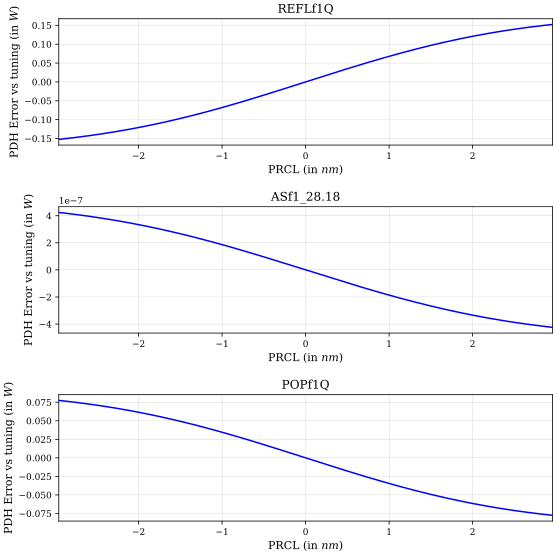

In [23]:
prmi=prmi5.deepcopy()
prmi.REFLf1.phase=opt_demod_R
prmi.ASf1.phase=opt_demod_A
prmi.POPf1.phase=opt_demod_P

prmi.parse("xaxis(PRM.phi,lin,-1,1,10000)") #Restricting to 1 deg, since the linear region ended within (-1,1).
out=prmi.run()
REFLf1Q=[]
ASf1_28=[]
POPf1Q=[]

# Plotting the corresponding length change (Microscopic tuning is used in Finesse)
limit=1*1064/360 

del_prcl=np.linspace(-limit,limit,10000)
out=prmi.run()

import matplotlib.pyplot as plt
for i in range(10000):
    REFLf1Q.append(out["REFLf1"][i])
    ASf1_28.append(out["ASf1"][i])
    POPf1Q.append(out["POPf1"][i])
    
fig,plots=plt.subplots(3,figsize=(8,8),sharex=False)

plots[0].plot(del_prcl,REFLf1Q)
plots[0].set_title("REFLf1Q")
plots[0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0].set_xlabel("PRCL (in $nm$)")

plots[1].plot(del_prcl,ASf1_28)
plots[1].set_title("ASf1_28.18")
plots[1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1].set_xlabel("PRCL (in $nm$)")

plots[2].plot(del_prcl,POPf1Q)
plots[2].set_title("POPf1Q")
plots[2].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2].set_xlabel("PRCL (in $nm$)")


fig.tight_layout()

In [25]:
### PRCL =>
#Calculating the slope of the signal using polyfit of order1
s_REFLf1_p=np.polyfit(prcl*1e-9,REFLf1Q,1)[0] # prcl was in nm, therefore 1e-9 is multiplied.
s_ASf1_p=np.polyfit(prcl*1e-9,ASf1_28,1)[0]
s_POPf1_p=np.polyfit(prcl*1e-9,POPf1Q,1)[0]

sig_REFLf1_p="{:e}".format(s_REFLf1_p)
sig_ASf1_p="{:e}".format(s_ASf1_p)
sig_POPf1_p="{:e}".format(s_POPf1_p)


In [26]:
### Plotting the dc readaouts+Pdh signals:
prmi.parse("""
pd REFL_dc PRM.p1.o 
pd AS_dc BS.p4.o
pd POP_dc PRM.p2.o
xaxis(PRM.phi,lin,-200,200,10000)""")

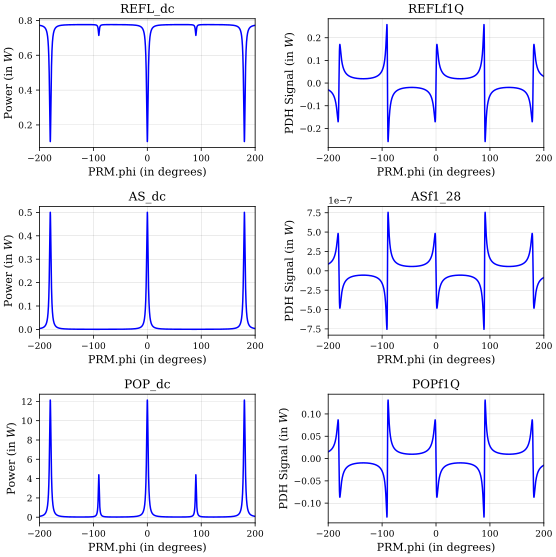

In [27]:
REFL_dc=[]
AS_dc=[]
POP_dc=[]

REFLf1Q=[]
ASf1_28=[]
POPf1Q=[]
out=prmi.run()

for i in range(10000):
    REFL_dc.append(out["REFL_dc"][i])
    AS_dc.append(out["AS_dc"][i])
    POP_dc.append(out["POP_dc"][i])
    
    REFLf1Q.append(out["REFLf1"][i])
    ASf1_28.append(out["ASf1"][i])
    POPf1Q.append(out["POPf1"][i])
fig,a=plt.subplots(3,2,figsize=(8,8))
a[0,0].plot(phi,REFL_dc)
a[0,0].set_xlabel("PRM.phi (in degrees)")
a[0,0].set_ylabel("Power (in $W$)")
a[0,0].set_title("REFL_dc")

a[0,1].plot(phi,REFLf1Q)
a[0,1].set_xlabel("PRM.phi (in degrees)")
a[0,1].set_ylabel("PDH Signal (in $W$)")
a[0,1].set_title("REFLf1Q")

a[1,0].plot(phi,AS_dc)
a[1,0].set_xlabel("PRM.phi (in degrees)")
a[1,0].set_ylabel("Power (in $W$)")
a[1,0].set_title("AS_dc")

a[1,1].plot(phi,ASf1_28)
a[1,1].set_xlabel("PRM.phi (in degrees)")
a[1,1].set_ylabel("PDH Signal (in $W$)")
a[1,1].set_title("ASf1_28")

a[2,0].plot(phi,POP_dc)
a[2,0].set_xlabel("PRM.phi (in degrees)")
a[2,0].set_ylabel("Power (in $W$)")
a[2,0].set_title("POP_dc")

a[2,1].plot(phi,POPf1Q)
a[2,1].set_xlabel("PRM.phi (in degrees)")
a[2,1].set_ylabel("PDH Signal (in $W$)")
a[2,1].set_title("POPf1Q")
fig.tight_layout()

Next, MICH is dithered.

In [28]:
prmi5.parse("xaxis(ITMy.phi,lin,-2,2,100)")
phase=np.linspace(0,90,100)
slope_R=[]
slope_A=[]
slope_P=[]
for i in np.linspace(0,90,100):
    prmi5.REFLf1.phase=i
    prmi5.ASf1.phase=i
    prmi5.POPf1.phase=i
    out=prmi5.run()
    
    slope_R.append(abs(0.01*(out["REFLf1"][0]-out["REFLf1"][-1])))
    slope_A.append(abs(0.01*(out["ASf1"][0]-out["ASf1"][-1])))
    slope_P.append(abs(0.01*(out["POPf1"][0]-out["POPf1"][-1])))
opt_demod_R=phase[slope_R.index(max(slope_R))]
opt_demod_A=phase[slope_A.index(max(slope_A))]
opt_demod_P=phase[slope_P.index(max(slope_P))]
print("Optimized demod phase for REFLf1:",opt_demod_R,"deg")
print("Optimized demod phase for ASf1:",opt_demod_A,"deg")
print("Optimized demod phase for POPf1:",opt_demod_P,"deg")

Optimized demod phase for REFLf1: 90.0 deg
Optimized demod phase for ASf1: 32.72727272727273 deg
Optimized demod phase for POPf1: 90.0 deg


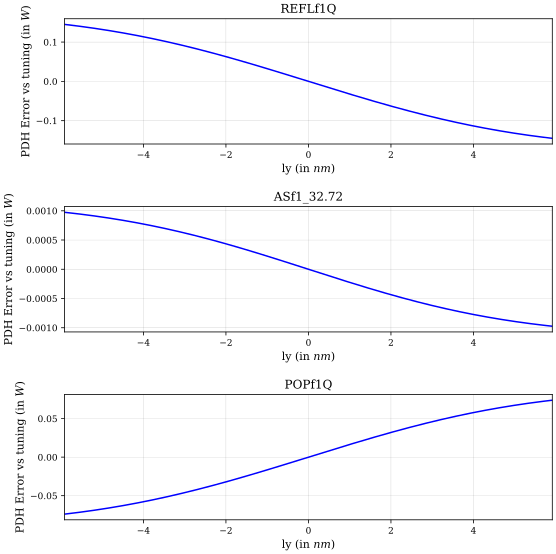

In [29]:
prmi=prmi5.deepcopy()
prmi.REFLf1.phase=opt_demod_R
prmi.ASf1.phase=opt_demod_A
prmi.POPf1.phase=opt_demod_P

prmi.parse("xaxis(ITMy.phi,lin,-2,2,10000)") #Restricting to 2 deg, since the linear region ended within (-2,2).
out=prmi.run()
REFLf1Q=[]
ASf1_32=[]
POPf1Q=[]

# Plotting the corresponding length change (Microscopic tuning is used in Finesse)
limit=2*1064/360 

del_ly=np.linspace(-limit,limit,10000)
out=prmi.run()

import matplotlib.pyplot as plt
for i in range(10000):
    REFLf1Q.append(out["REFLf1"][i])
    ASf1_32.append(out["ASf1"][i])
    POPf1Q.append(out["POPf1"][i])
    
fig,plots=plt.subplots(3,figsize=(8,8),sharex=False)

plots[0].plot(del_ly,REFLf1Q)
plots[0].set_title("REFLf1Q")
plots[0].set_ylabel("PDH Error vs tuning (in $W$)")
plots[0].set_xlabel("ly (in $nm$)")

plots[1].plot(del_ly,ASf1_32)
plots[1].set_title("ASf1_32.72")
plots[1].set_ylabel("PDH Error vs tuning (in $W$)")
plots[1].set_xlabel("ly (in $nm$)")

plots[2].plot(del_ly,POPf1Q)
plots[2].set_title("POPf1Q")
plots[2].set_ylabel("PDH Error vs tuning (in $W$)")
plots[2].set_xlabel("ly (in $nm$)")


fig.tight_layout()

In [30]:
### MICH =>
#Calculating the slope of the signal using polyfit of order1
s_REFLf1_m=np.polyfit(ly*1e-9,REFLf1Q,1)[0]# ly was in nm, therefore 1e-9 is multiplied.
s_ASf1_m=np.polyfit(ly*1e-9,ASf1_32,1)[0]
s_POPf1_m=np.polyfit(ly*1e-9,POPf1Q,1)[0]

sig_REFLf1_m="{:e}".format(0.5*s_REFLf1_p-s_REFLf1_m) # the required algebra
sig_ASf1_m="{:e}".format(0.5*s_ASf1_p-s_ASf1_m)
sig_POPf1_m="{:e}".format(0.5*s_POPf1_p-s_POPf1_m)

In [31]:
### Plotting the a readouts:
prmi.parse("""
pd REFL_dc PRM.p1.o 
pd AS_dc BS.p4.o
pd POP_dc PRM.p2.o
xaxis(ITMy.phi,lin,-200,200,10000)""")

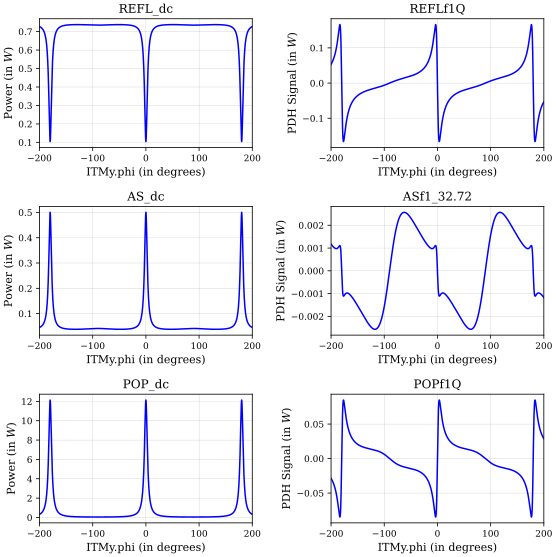

In [32]:
REFL_dc=[]
AS_dc=[]
POP_dc=[]

REFLf1Q=[]
ASf1_32=[]
POPf1Q=[]
out=prmi.run()

for i in range(10000):
    REFL_dc.append(out["REFL_dc"][i])
    AS_dc.append(out["AS_dc"][i])
    POP_dc.append(out["POP_dc"][i])
    
    REFLf1Q.append(out["REFLf1"][i])
    ASf1_32.append(out["ASf1"][i])
    POPf1Q.append(out["POPf1"][i])
fig,a=plt.subplots(3,2,figsize=(8,8))
a[0,0].plot(phi,REFL_dc)
a[0,0].set_xlabel("ITMy.phi (in degrees)")
a[0,0].set_ylabel("Power (in $W$)")
a[0,0].set_title("REFL_dc")

a[0,1].plot(phi,REFLf1Q)
a[0,1].set_xlabel("ITMy.phi (in degrees)")
a[0,1].set_ylabel("PDH Signal (in $W$)")
a[0,1].set_title("REFLf1Q")

a[1,0].plot(phi,AS_dc)
a[1,0].set_xlabel("ITMy.phi (in degrees)")
a[1,0].set_ylabel("Power (in $W$)")
a[1,0].set_title("AS_dc")

a[1,1].plot(phi,ASf1_32)
a[1,1].set_xlabel("ITMy.phi (in degrees)")
a[1,1].set_ylabel("PDH Signal (in $W$)")
a[1,1].set_title("ASf1_32.72")

a[2,0].plot(phi,POP_dc)
a[2,0].set_xlabel("ITMy.phi (in degrees)")
a[2,0].set_ylabel("Power (in $W$)")
a[2,0].set_title("POP_dc")

a[2,1].plot(phi,POPf1Q)
a[2,1].set_xlabel("ITMy.phi (in degrees)")
a[2,1].set_ylabel("PDH Signal (in $W$)")
a[2,1].set_title("POPf1Q")
fig.tight_layout()

In [33]:
from tabulate import tabulate
M=[["Signal","REFLf1Q","ASf1_28.18","POPf1Q","ASf1_32.72"],
   ["PRCL (in W/m)",sig_REFLf1_p,sig_ASf1_p,sig_POPf1_p,"-"],
   ["MICH (in W/m)",sig_REFLf1_m,"-",sig_POPf1_m,sig_ASf1_m]]
print(tabulate(M))

-------------  ------------  -------------  -------------  ------------
Signal         REFLf1Q       ASf1_28.18     POPf1Q         ASf1_32.72
PRCL (in W/m)  5.821987e+07  -1.611460e+02  -2.960219e+07  -
MICH (in W/m)  5.651116e+07  -              -2.876964e+07  1.861329e+05
-------------  ------------  -------------  -------------  ------------
